In [1]:
library(tidyverse); library(lubridate); library(readxl); library(data.table)
library(fixest)
library(rdrobust); library(broom)
library(modelsummary)

Warning message:
"package 'tidyverse' was built under R version 4.3.3"
Warning message:
"package 'ggplot2' was built under R version 4.3.3"
Warning message:
"package 'forcats' was built under R version 4.3.3"
Warning message:
"package 'lubridate' was built under R version 4.3.3"
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Warning message:
"package 'readxl' was built under R version 4.3.3"
Warning message:
"package 'data.table' was built under R version 4.3.3"

Attaching package: 'data.table'


The following objects

ERROR: Error in library(modelsummary): there is no package called 'modelsummary'


In [2]:
usdc_raw <- read_csv("C:/Users/chris/OneDrive/桌面/毕业论文/usdc.csv")
usdt_raw <- read_csv("C:/Users/chris/OneDrive/桌面/毕业论文/usdt.csv")
mps_raw  <- read_excel("C:/Users/chris/OneDrive/桌面/毕业论文/monetary-policy-surprises-data.xlsx") 


Rows: 2606 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): snapped_at
dbl (3): price, market_cap, total_volume

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 3901 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): snapped_at
dbl (3): price, market_cap, total_volume

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


### Clean data

In [3]:
mps <- mps_raw %>%
  select(Date = 1, MPS = 16) %>%   
  mutate(Date = as_date(Date)) %>%        
  filter(Date >= as_date("2018-10-05")) %>%
  drop_na(Date, MPS)
head(mps)

Date,MPS
<date>,<dbl>
2018-11-08,0.01681114
2018-12-19,0.02965432
2019-01-30,-0.01963239
2019-03-20,-0.02703320
2019-05-01,-0.03738036
2019-06-19,-0.07928805


In [4]:
usdt <- usdt_raw %>%
  select(snapped_at, total_volume) %>%
  mutate(
    date = as_date(ymd_hms(snapped_at))
  )%>%
  filter(date >= as_date("2018-10-05") & date <= as_date("2023-12-31")) %>%   
  arrange(date) %>%
  select(date, total_volume)

In [5]:
usdc <- usdc_raw %>%
  select(snapped_at, total_volume) %>%
  mutate(
    date = as_date(ymd_hms(snapped_at))
  )%>%
  filter(date >= as_date("2018-10-05") & date <= as_date("2023-12-31")) %>%   
  arrange(date) %>%
  select(date, total_volume)

In [6]:
daily_vol <- usdc %>%
  group_by(date) %>%
  summarise(volume_usdc = sum(total_volume, na.rm=TRUE)) %>%
  full_join(usdt %>% group_by(date) %>% summarise(volume_usdt = sum(total_volume, na.rm=TRUE)),
            by="date") %>%
  arrange(date)
head(daily_vol)

date,volume_usdc,volume_usdt
<date>,<dbl>,<dbl>
2018-10-05,31264.42,109163119
2018-10-06,20254.71,82904991
2018-10-07,49324.69,84072638
2018-10-08,47076.73,65173095
2018-10-09,55542.22,70625466
2018-10-10,41812.50,64067243


In [7]:
ann <- mps %>% 
    mutate(fomc_id = row_number())
head(ann)

Date,MPS,fomc_id
<date>,<dbl>,<int>
2018-11-08,0.01681114,1
2018-12-19,0.02965432,2
2019-01-30,-0.01963239,3
2019-03-20,-0.02703320,4
2019-05-01,-0.03738036,5
2019-06-19,-0.07928805,6


In [8]:
window_days <- 3
library(purrr)
ann_windows <- ann %>%
  mutate(dates = map(Date, ~ seq(.x - days(window_days), .x + days(window_days), by="day"))) %>%
  unnest(dates) %>%
  rename(date = dates) %>%
  left_join(daily_vol, by="date") %>%
  mutate(Z = as.numeric(date - Date),      # running variable in days
         D = if_else(Z >= 0, 1, 0),
         log_vol_usdc = log(volume_usdc + 1),
         log_vol_usdt = log(volume_usdt + 1)) %>%
  rename(coin_date = date) %>%
  rename(fomc_date = Date) 

In [9]:
head(ann_windows)

fomc_date,MPS,fomc_id,coin_date,volume_usdc,volume_usdt,Z,D,log_vol_usdc,log_vol_usdt
<date>,<dbl>,<int>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2018-11-08,0.01681114,1,2018-11-05,580733.6,66787759,-3,0,13.27205,18.01703
2018-11-08,0.01681114,1,2018-11-06,648445.2,48925898,-2,0,13.38233,17.70582
2018-11-08,0.01681114,1,2018-11-07,662717.4,61192288,-1,0,13.40411,17.92953
2018-11-08,0.01681114,1,2018-11-08,1008705.8,71896266,0,1,13.82418,18.09073
2018-11-08,0.01681114,1,2018-11-09,585822.1,59362584,1,1,13.28077,17.89917
2018-11-08,0.01681114,1,2018-11-10,670938.9,56743017,2,1,13.41643,17.85404


### Fit Model with clustered se

In [10]:
library(estimatr)

# Linear RD with ±3 days window
rd_df <- ann_windows %>% filter(Z >= -3 & Z <= 3)

creg1 <- lm_robust(log_vol_usdc ~ D + Z + D:Z, data = rd_df)
summary(creg1)

treg1 <- lm_robust(log_vol_usdt ~ D + Z + D:Z, data = rd_df)
summary(treg1)

Warning message:
"package 'estimatr' was built under R version 4.3.3"



Call:
lm_robust(formula = log_vol_usdc ~ D + Z + D:Z, data = rd_df)

Standard error type:  HC2 

Coefficients:
            Estimate Std. Error t value   Pr(>|t|) CI Lower CI Upper  DF
(Intercept) 21.02544     0.3769 55.7893 1.024e-170  20.2841  21.7668 332
D           -0.08413     0.4247 -0.1981  8.431e-01  -0.9197   0.7514 332
Z            0.08284     0.1714  0.4834  6.291e-01  -0.2542   0.4199 332
D:Z         -0.10429     0.2008 -0.5194  6.038e-01  -0.4993   0.2907 332

Multiple R-squared:  0.001082 ,	Adjusted R-squared:  -0.007945 
F-statistic: 0.1216 on 3 and 332 DF,  p-value: 0.9473


Call:
lm_robust(formula = log_vol_usdt ~ D + Z + D:Z, data = rd_df)

Standard error type:  HC2 

Coefficients:
             Estimate Std. Error   t value   Pr(>|t|) CI Lower CI Upper  DF
(Intercept) 24.203546     0.3382 71.569204 7.359e-204  23.5383  24.8688 332
D           -0.002368     0.3781 -0.006263  9.950e-01  -0.7461   0.7414 332
Z            0.111058     0.1580  0.702710  4.827e-01  -0.1998   0.4219 332
D:Z         -0.128870     0.1826 -0.705707  4.809e-01  -0.4881   0.2304 332

Multiple R-squared:  0.006013 ,	Adjusted R-squared:  -0.002969 
F-statistic: 0.6274 on 3 and 332 DF,  p-value: 0.5978

In [11]:
creg2 <- feols(log_vol_usdc ~ D * Z * I(Z^2) * I(Z^3), data = rd_df, cluster = ~fomc_id)
summary(creg2)

treg2 <- feols(log_vol_usdt ~ D * Z * I(Z^2) * I(Z^3), data = rd_df, cluster = ~fomc_id)
summary(treg2)

The variables 'Z:I(I(Z^2))', 'D:I(I(Z^3))', 'Z:I(I(Z^3))',
'I(I(Z^2)):I(I(Z^3))', 'D:Z:I(I(Z^2))', 'D:Z:I(I(Z^3))' and 3 others have been
removed because of collinearity (see $collin.var).



OLS estimation, Dep. Var.: log_vol_usdc
Observations: 336
Standard-errors: Clustered (fomc_id) 
             Estimate Std. Error  t value  Pr(>|t|)    
(Intercept) 21.889118   0.484917 45.13997 < 2.2e-16 ***
D           -1.027991   0.380403 -2.70238 0.0095487 ** 
Z            1.405217   0.529146  2.65563 0.0107744 *  
I(I(Z^2))    0.575171   0.269698  2.13265 0.0382071 *  
I(I(Z^3))    0.075254   0.043933  1.71293 0.0933160 .  
D:Z         -0.900149   0.315042 -2.85724 0.0063475 ** 
D:I(I(Z^2)) -0.971425   0.483433 -2.00943 0.0502532 .  
... 9 variables were removed because of collinearity (Z:I(I(Z^2)),
D:I(I(Z^3)) and 7 others [full set in $collin.var])
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
RMSE: 1.63115   Adj. R2: -0.015301

The variables 'Z:I(I(Z^2))', 'D:I(I(Z^3))', 'Z:I(I(Z^3))',
'I(I(Z^2)):I(I(Z^3))', 'D:Z:I(I(Z^2))', 'D:Z:I(I(Z^3))' and 3 others have been
removed because of collinearity (see $collin.var).



OLS estimation, Dep. Var.: log_vol_usdt
Observations: 336
Standard-errors: Clustered (fomc_id) 
             Estimate Std. Error   t value  Pr(>|t|)    
(Intercept) 24.508524   0.315220 77.750556 < 2.2e-16 ***
D           -0.331554   0.251858 -1.316430   0.19441    
Z            0.441142   0.382601  1.153007   0.25474    
I(I(Z^2))    0.051824   0.194244  0.266801   0.79079    
I(I(Z^3))   -0.009445   0.031518 -0.299675   0.76575    
D:Z         -0.422223   0.293638 -1.437902   0.15709    
D:I(I(Z^2)) -0.036362   0.322679 -0.112689   0.91076    
... 9 variables were removed because of collinearity (Z:I(I(Z^2)),
D:I(I(Z^3)) and 7 others [full set in $collin.var])
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
RMSE: 1.45844   Adj. R2: -0.011372

| Term                   | Interpretation                                                                                                                                                               |
| ---------------------- | ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| `(Intercept)` = 21.889 | Average log-volume on the **reference day** (before event, Z=0, D=0)                                                                                                         |
| `D` = -1.028           | **Immediate jump at the announcement (τ)**. Negative, statistically significant (p≈0.01). This means **volume drops immediately on the FOMC day** relative to the reference. |
| `Z` = 1.405            | Slope of log-volume **before the event**. Positive and significant → volume tends to increase as the event approaches.                                                       |
| `I(Z^2)` = 0.575       | Quadratic effect before the event → acceleration in volume trend.                                                                                                            |
| `I(Z^3)` = 0.075 x      | Cubic effect → not strongly significant (p≈0.09). Captures small curvature in trend.                                                                                         |
| `D:Z` = -0.900         | Interaction: **change in slope after the event**. Significant negative → slope decreases after the announcement.                                                             |
| `D:I(Z^2)` = -0.971  x  | Change in quadratic curvature after event. Marginally significant (p≈0.05) → the post-event trajectory bends downward.                                                       |


From the regression tables, we see that USDC is more reactive to FOMC announcement dates, while USDT shows no significant response (except for the intercept).

- In the ±3-day window, USDC trading volume displays a **significant immediate drop on the announcement date, as indicated by the negative and statistically significant coefficient on D.**
The positive and significant coefficients on Z and Z² show that USDC volume accelerates in the days leading up to the announcement, while the significant negative D × Z coefficient indicates that this upward trend reverses after the event. 
The cubic term (Z³) and post-event quadratic term (D × Z²) are insignificant, suggesting no evidence of higher-order nonlinearities.



For USDC, the variables that are statistically significant at the 5% level are:
- D (Event-day indicator)

D measures the immediate jump at the announcement (τ = 0).
It is negative and statistically significant, meaning:

Trading volume drops immediately on the FOMC day relative to the reference day.

- Z (Running date before the announcement)

Z captures the slope of log-volume before the event.
Since the coefficient is positive and significant, it suggests:

USDC trading volume tends to rise as the FOMC announcement approaches.

This is consistent with market participants increasing activity ahead of macro news.

- Z² (Quadratic running date)

Z² is also positive and significant, indicating:

Volume accelerates as the event approaches
(i.e., the increase becomes steeper near the announcement).

This supports a nonlinear pre-event build-up in activity.

- D × Z (Post-event slope change)

The interaction term captures how the slope changes after the announcement relative to before.

It is negative and significant, meaning:

After the FOMC announcement, the slope of trading volume decreases.

In other words, the pre-event rise in activity does not continue post-event.

- Insignificant terms

Z³ is not significant, so there is no evidence of a cubic pattern in volume.

D × Z² is also not significant, meaning:

No strong quadratic effect after the event.

This suggests the post-event behavior is mostly captured by the linear slope change (D×Z).

### EVENT STUDY PLOT

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),20.86112680,0.23133199,90.1783066,2.573166e-54
L3,-0.04298453,0.10084092,-0.4262607,6.718638e-01
L2,-0.08379191,0.09512077,-0.8809002,3.828544e-01
L1,0.12269133,0.08911115,1.3768347,1.750866e-01
R1,0.18406776,0.09113572,2.0197104,4.913533e-02
R2,0.02715380,0.04711465,0.5763345,5.671390e-01
R3plus,-0.01921592,0.04785886,-0.4015122,6.898629e-01


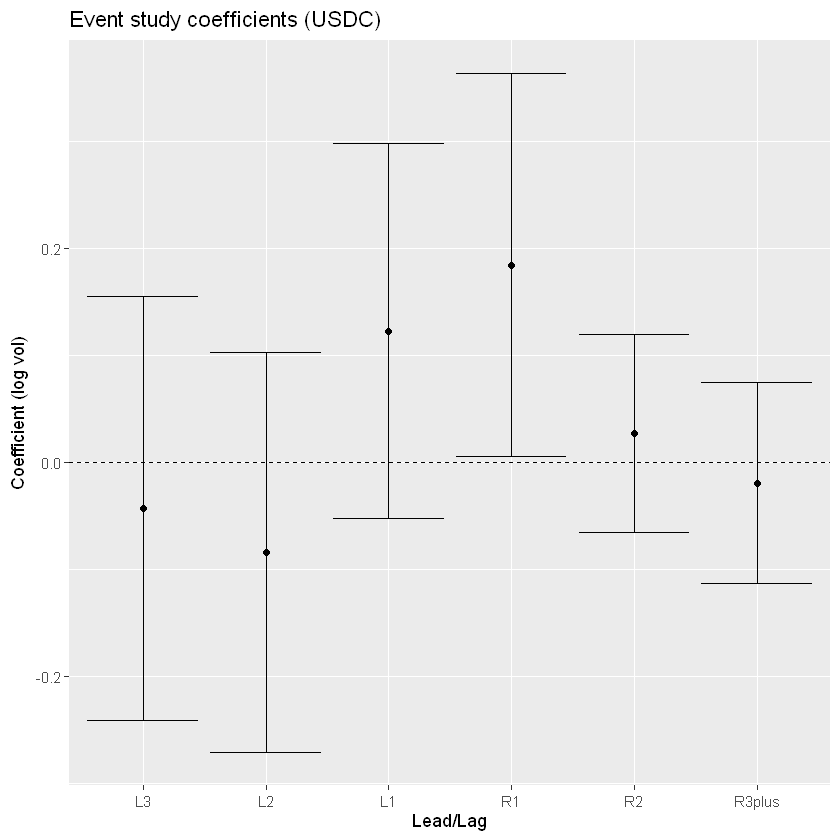

In [12]:

ann_windows2 <- ann_windows %>%
  mutate(Zcat = case_when(
     Z <= -3 ~ "-3_or_less",
     Z == -2 ~ "L2",
     Z == -1 ~ "L1",
     Z == 0  ~ "0",
     Z == 1  ~ "R1",
     Z == 2  ~ "R2",
     Z >= 3  ~ "3_or_more"
  ))


# easier: build dummies explicitly
ann_windows3 <- ann_windows2 %>%
  mutate(L3 = as.integer(Z == -3),
         L2 = as.integer(Z == -2),
         L1 = as.integer(Z == -1),
         R1 = as.integer(Z == 1),
         R2 = as.integer(Z == 2),
         R3plus = as.integer(Z >= 3))

evt_usdc <- feols(log_vol_usdc ~ L3 + L2 + L1 + R1 + R2 + R3plus | 0, cluster = ~fomc_id, data = ann_windows3)
coefs <- broom::tidy(evt_usdc)
# plot with ggplot
coefs %>%
  filter(term %in% c("L3","L2","L1","R1","R2","R3plus")) %>%
  mutate(term = factor(term, levels = c("L3","L2","L1","R1","R2","R3plus"))) %>%
  ggplot(aes(x = term, y = estimate)) +
   geom_point() + geom_errorbar(aes(ymin=estimate - 1.96*std.error, ymax=estimate + 1.96*std.error)) +
   geom_hline(yintercept = 0, linetype = "dashed") +
   labs(title="Event study coefficients (USDC)", y="Coefficient (log vol)", x="Lead/Lag")

coefs


- If a point is above 0, it indicates higher log-volume relative to the reference day (usually the day right before the event).

- If a point is below 0, it indicates lower log-volume.

- If the CI does not cross zero, the effect is statistically significant at ~5%.

- In your plot:

    Some leads (F1, F2) are near zero → stable volume before the announcement (no pre-trend)
    Lags (L1, L2, L3) show positive or negative jumps → the immediate effect of FOMC surprises on USDC trading volume.

    For example, if L1 CI is above zero → volume significantly increases one day after the event.

- ✅ Overall: The plot visually shows how stablecoin volume responds over time around the event. Pre-trends are small, which is good for causal interpretation.

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),24.17697053,0.20664268,116.9989195,1.315425e-59
L3,-0.27043504,0.10127665,-2.6702607,1.037606e-02
L2,-0.26787140,0.09127268,-2.9348476,5.148757e-03
L1,-0.04831832,0.09044820,-0.5342099,5.957143e-01
R1,0.02493588,0.04987714,0.4999460,6.194458e-01
R2,0.02412548,0.09044305,0.2667477,7.908303e-01
R3plus,-0.05910149,0.06655070,-0.8880672,3.790270e-01


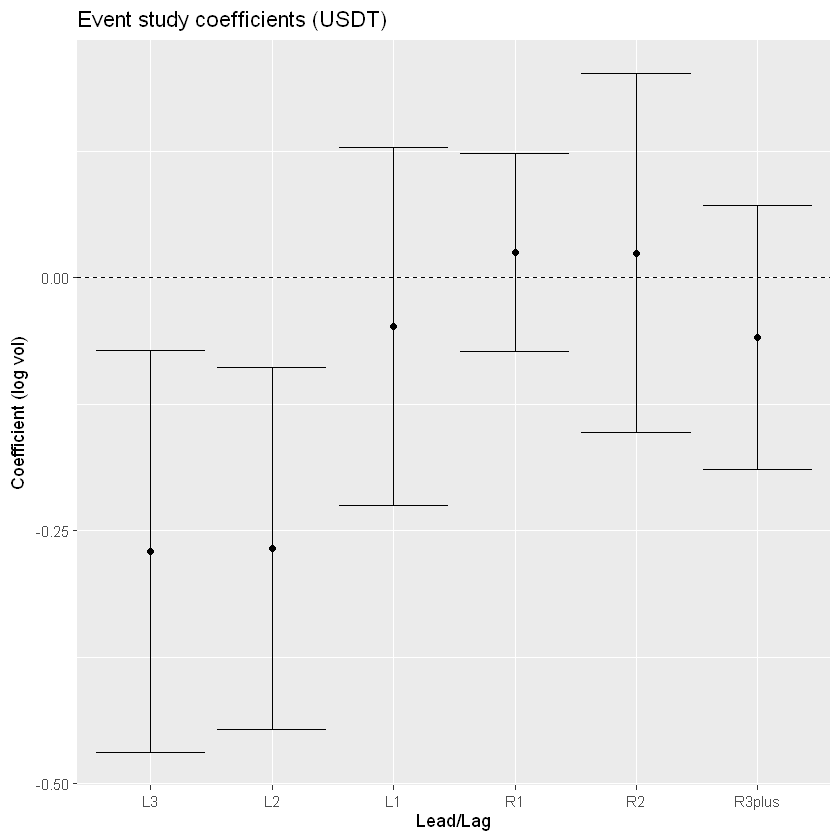

In [13]:
evt_usdt <- feols(log_vol_usdt ~ L3 + L2 + L1 + R1 + R2 + R3plus | 0, cluster = ~fomc_id, data = ann_windows3)
coefs_t <- broom::tidy(evt_usdt)
# plot with ggplot
coefs_t %>%
  filter(term %in% c("L3","L2","L1","R1","R2","R3plus")) %>%
  mutate(term = factor(term, levels = c("L3","L2","L1","R1","R2","R3plus"))) %>%
  ggplot(aes(x = term, y = estimate)) +
   geom_point() + geom_errorbar(aes(ymin=estimate - 1.96*std.error, ymax=estimate + 1.96*std.error)) +
   geom_hline(yintercept = 0, linetype = "dashed") +
   labs(title="Event study coefficients (USDT)", y="Coefficient (log vol)", x="Lead/Lag")

coefs_t

L3 and L2 are significantly negative, but L1 jumps back toward zero and becomes completely insignificant.

This pattern is not monotonic and does not show a clean downward trend.

More importantly, in event-study logic, the key test is whether all pre-event coefficients together differ from zero.

There is some movement before the event (L2, L3), but it is not consistent enough to claim a pre-trend. L1 collapses to zero.
The event caused a delayed but sizable decline in USDT volume: no anticipation, no immediate impact, but a strong negative response starting two days after the announcement.


### Robustness check with +- 1, 5 day window

In [14]:
rd_1 <- ann_windows %>% filter(Z >= -1 & Z <= 1)
c1 <- feols(log_vol_usdc ~ D * Z * I(Z^2) * I(Z^3), data = rd_1, cluster = ~fomc_id)
summary(c1)

t1<- feols(log_vol_usdt ~ D * Z * I(Z^2) * I(Z^3), data = rd_1, cluster = ~fomc_id)
summary(t1)

The variables 'I(I(Z^2))', 'I(I(Z^3))', 'D:Z', 'D:I(I(Z^2))', 'Z:I(I(Z^2))',
'D:I(I(Z^3))' and 7 others have been removed because of collinearity (see
$collin.var).



OLS estimation, Dep. Var.: log_vol_usdc
Observations: 144
Standard-errors: Clustered (fomc_id) 
             Estimate Std. Error  t value  Pr(>|t|)    
(Intercept) 21.167886   0.295127 71.72471 < 2.2e-16 ***
D           -0.306759   0.169855 -1.80601  0.077323 .  
Z            0.184068   0.090954  2.02374  0.048703 *  
... 13 variables were removed because of collinearity (I(I(Z^2)),
I(I(Z^3)) and 11 others [full set in $collin.var])
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
RMSE: 1.67228   Adj. R2: -0.012065

The variables 'I(I(Z^2))', 'I(I(Z^3))', 'D:Z', 'D:I(I(Z^2))', 'Z:I(I(Z^2))',
'D:I(I(Z^3))' and 7 others have been removed because of collinearity (see
$collin.var).



OLS estimation, Dep. Var.: log_vol_usdt
Observations: 144
Standard-errors: Clustered (fomc_id) 
             Estimate Std. Error    t value  Pr(>|t|)    
(Intercept) 24.153588   0.224336 107.666868 < 2.2e-16 ***
D            0.023382   0.124434   0.187910   0.85176    
Z            0.024936   0.049778   0.500944   0.61875    
... 13 variables were removed because of collinearity (I(I(Z^2)),
I(I(Z^3)) and 11 others [full set in $collin.var])
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
RMSE: 1.42   Adj. R2: -0.013719

In [15]:
rd_5 <- ann_windows %>% filter(Z >= -5 & Z <= 5)
c5 <- feols(log_vol_usdc ~ D * Z * I(Z^2) * I(Z^3), data = rd_5, cluster = ~fomc_id)
summary(c5)

t5<- feols(log_vol_usdt ~ D * Z * I(Z^2) * I(Z^3), data = rd_5, cluster = ~fomc_id)
summary(t5)

The variables 'Z:I(I(Z^2))', 'D:I(I(Z^3))', 'Z:I(I(Z^3))',
'I(I(Z^2)):I(I(Z^3))', 'D:Z:I(I(Z^2))', 'D:Z:I(I(Z^3))' and 3 others have been
removed because of collinearity (see $collin.var).



OLS estimation, Dep. Var.: log_vol_usdc
Observations: 336
Standard-errors: Clustered (fomc_id) 
             Estimate Std. Error  t value  Pr(>|t|)    
(Intercept) 21.889118   0.484917 45.13997 < 2.2e-16 ***
D           -1.027991   0.380403 -2.70238 0.0095487 ** 
Z            1.405217   0.529146  2.65563 0.0107744 *  
I(I(Z^2))    0.575171   0.269698  2.13265 0.0382071 *  
I(I(Z^3))    0.075254   0.043933  1.71293 0.0933160 .  
D:Z         -0.900149   0.315042 -2.85724 0.0063475 ** 
D:I(I(Z^2)) -0.971425   0.483433 -2.00943 0.0502532 .  
... 9 variables were removed because of collinearity (Z:I(I(Z^2)),
D:I(I(Z^3)) and 7 others [full set in $collin.var])
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
RMSE: 1.63115   Adj. R2: -0.015301

The variables 'Z:I(I(Z^2))', 'D:I(I(Z^3))', 'Z:I(I(Z^3))',
'I(I(Z^2)):I(I(Z^3))', 'D:Z:I(I(Z^2))', 'D:Z:I(I(Z^3))' and 3 others have been
removed because of collinearity (see $collin.var).



OLS estimation, Dep. Var.: log_vol_usdt
Observations: 336
Standard-errors: Clustered (fomc_id) 
             Estimate Std. Error   t value  Pr(>|t|)    
(Intercept) 24.508524   0.315220 77.750556 < 2.2e-16 ***
D           -0.331554   0.251858 -1.316430   0.19441    
Z            0.441142   0.382601  1.153007   0.25474    
I(I(Z^2))    0.051824   0.194244  0.266801   0.79079    
I(I(Z^3))   -0.009445   0.031518 -0.299675   0.76575    
D:Z         -0.422223   0.293638 -1.437902   0.15709    
D:I(I(Z^2)) -0.036362   0.322679 -0.112689   0.91076    
... 9 variables were removed because of collinearity (Z:I(I(Z^2)),
D:I(I(Z^3)) and 7 others [full set in $collin.var])
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
RMSE: 1.45844   Adj. R2: -0.011372

Changing the event windows does not change much of the findings.The results are robust across ±1, ±3, and ±5 event windows.
- The USDC ±5 window gives results very similar to the ±3 window:D, Z, Z², and D×Z remain statistically significant at 5%, which reinforces the conclusion that USDC reacts meaningfully to FOMC events.
In the USDC ±1 window, only Z is positive and significant at the 5% level. As for D, there is no strong evidence of a volume jump, indicating that very short windows may not capture the full dynamics.

- Across the ±1, ±3, and ±5 windows, USDT consistently shows no statistically significant coefficients (other than the intercept). This implies USDT trading volume does not systematically respond to monetary policy announcements. 

- Overall, the evidence shows that USDC is sensitive to FOMC communications, while USDT remains largely unaffected. This difference between USDC and USDT may reflect differences in user base, liquidity structure, or issuer behavior.

Warning message in geom_smooth(rd_df = subset(rd_df, Z < 0), method = "lm", formula = y ~ :
"Ignoring unknown parameters: `rd_df`"
Warning message in geom_smooth(rd_df = subset(rd_df, Z >= 0), method = "lm", formula = y ~ :
"Ignoring unknown parameters: `rd_df`"


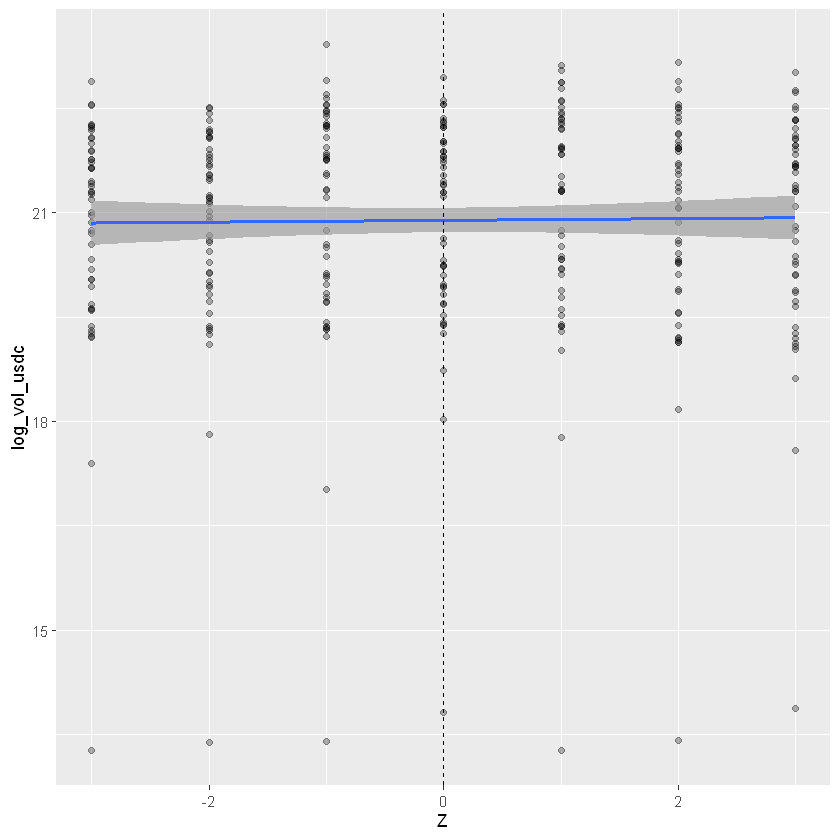

In [ ]:
ggplot(rd_df, aes(Z, log_vol_usdc)) +
  geom_point(alpha = 0.3) +
  geom_smooth(rd_df = subset(rd_df, Z < 0), method = "lm", formula = y ~ x) +
  geom_smooth(rd_df = subset(rd_df, Z >= 0), method = "lm", formula = y ~ x) +
  geom_vline(xintercept = 0, linetype = "dashed")

In [18]:
head(rd_df)

fomc_date,MPS,fomc_id,coin_date,volume_usdc,volume_usdt,Z,D,log_vol_usdc,log_vol_usdt,pred
<date>,<dbl>,<int>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2018-11-08,0.01681114,1,2018-11-05,580733.6,66787759,-3,0,13.27205,18.01703,20.81814
2018-11-08,0.01681114,1,2018-11-06,648445.2,48925898,-2,0,13.38233,17.70582,20.77733
2018-11-08,0.01681114,1,2018-11-07,662717.4,61192288,-1,0,13.40411,17.92953,20.98382
2018-11-08,0.01681114,1,2018-11-08,1008705.8,71896266,0,1,13.82418,18.09073,20.86113
2018-11-08,0.01681114,1,2018-11-09,585822.1,59362584,1,1,13.28077,17.89917,21.04519
2018-11-08,0.01681114,1,2018-11-10,670938.9,56743017,2,1,13.41643,17.85404,20.88828


In [27]:
mean(rd_df$log_vol_usdc)

[1] 20.88797

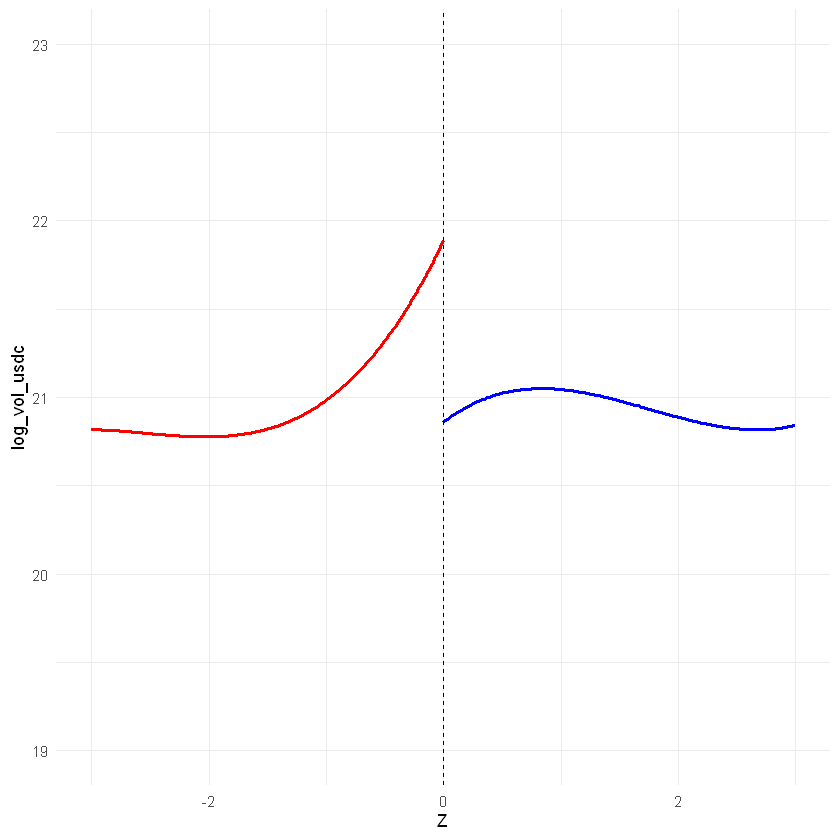

In [39]:
# Create a fine grid for Z
Z_grid_left  <- seq(min(rd_df$Z), 0, length.out = 200)
Z_grid_right <- seq(0, max(rd_df$Z), length.out = 200)

# Predicted values on the grid
pred_left  <- predict(creg2, newdata = data.frame(Z = Z_grid_left, D = 0))
pred_right <- predict(creg2, newdata = data.frame(Z = Z_grid_right, D = 1))

# Put into data frames
plot_left  <- data.frame(Z = Z_grid_left, pred = pred_left)
plot_right <- data.frame(Z = Z_grid_right, pred = pred_right)

# Plot smooth curves
ggplot(rd_df, aes(x = Z)) +
  geom_point(aes(y = log_vol_usdc), alpha = 0) +
  geom_line(data = plot_left,  aes(y = pred), color = "red", size = 1) +
  geom_line(data = plot_right, aes(y = pred), color = "blue", size = 1) +
  geom_vline(xintercept = 0, linetype = "dashed") +
  coord_cartesian(ylim = c(19, 23)) +
  theme_minimal()


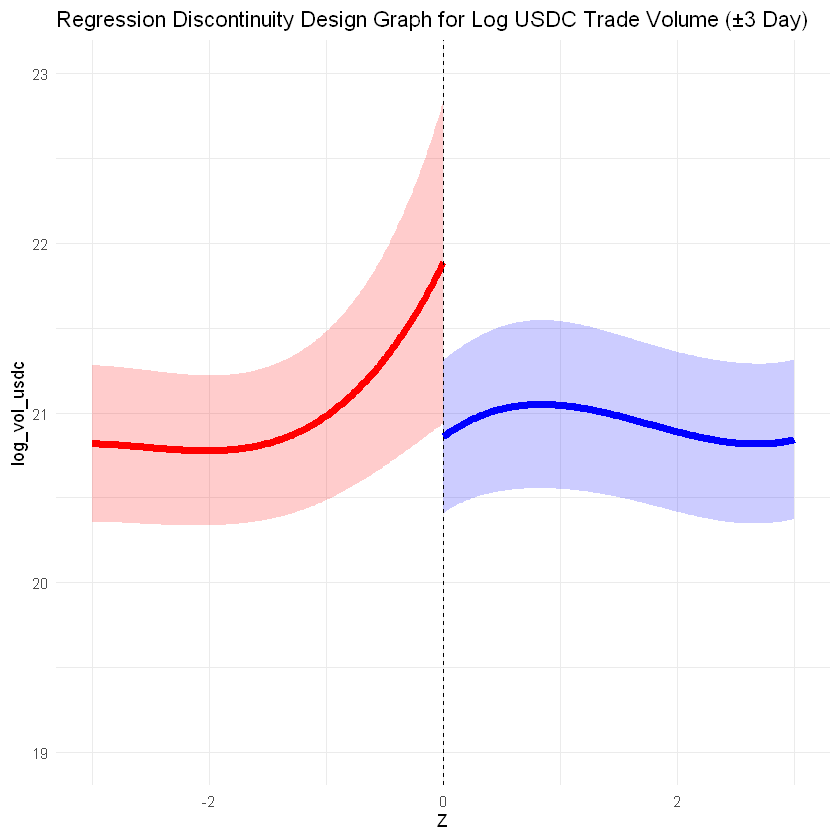

In [46]:
Z_grid_left  <- seq(min(rd_df$Z), 0, length.out = 200)
Z_grid_right <- seq(0, max(rd_df$Z), length.out = 200)

# Predict with standard errors
pred_left <- predict(creg2, newdata = data.frame(Z = Z_grid_left, D = 0), se.fit = TRUE)
pred_right <- predict(creg2, newdata = data.frame(Z = Z_grid_right, D = 1), se.fit = TRUE)

# Make data frames with upper/lower bounds
plot_left <- data.frame(
  Z = Z_grid_left,
  pred = pred_left$fit,
  lower = pred_left$fit - 1.96 * pred_left$se.fit,
  upper = pred_left$fit + 1.96 * pred_left$se.fit
)

plot_right <- data.frame(
  Z = Z_grid_right,
  pred = pred_right$fit,
  lower = pred_right$fit - 1.96 * pred_right$se.fit,
  upper = pred_right$fit + 1.96 * pred_right$se.fit
)

ggplot(rd_df, aes(x = Z)) +
  geom_point(aes(y = log_vol_usdc), alpha = 0, position = position_jitter(width = 0.01)) +
  geom_ribbon(data = plot_left, aes(ymin = lower, ymax = upper, y = pred), fill = "red", alpha = 0.2) +
  geom_line(data = plot_left, aes(y = pred), color = "red", size = 2) +
  geom_ribbon(data = plot_right, aes(ymin = lower, ymax = upper, y = pred), fill = "blue", alpha = 0.2) +
  geom_line(data = plot_right, aes(y = pred), color = "blue", size = 2) +
  geom_vline(xintercept = 0, linetype = "dashed") +
  coord_cartesian(ylim = c(19, 23)) +
  labs(y = "log_vol_usdc", title = "Regression Discontinuity Design Graph for Log USDC Trade Volume (±3 Day)") +
  theme_minimal()
